<a href="https://colab.research.google.com/github/rnjsxodyd90/Ensemble-model-with-mobile-vggnet/blob/main/Ensemble_model_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For making a dataframe - confusion matrix later

In [3]:
import os
import shutil
from random import shuffle

def downsample_data(source, target_count):
    files = os.listdir(source)
    shuffle(files)
    # Reduce the number of files to the target count
    files = files[:target_count]
    return files

def split_data(files, source, dest_train, dest_val, dest_test, train_size=0.6, val_size=0.2):
    # Ensure the randomness is reproducible
    shuffle(files)

    # Calculate split indices
    n = len(files)
    train_end = int(train_size * n)
    val_end = train_end + int(val_size * n)

    # Create destination directories if they don't exist
    os.makedirs(dest_train, exist_ok=True)
    os.makedirs(dest_val, exist_ok=True)
    os.makedirs(dest_test, exist_ok=True)

    # Copy files to their new locations
    for i, file in enumerate(files):
        if i < train_end:
            shutil.copy(os.path.join(source, file), dest_train)
        elif i < val_end:
            shutil.copy(os.path.join(source, file), dest_val)
        else:
            shutil.copy(os.path.join(source, file), dest_test)

# Paths to the source folders
source_normal = '/content/drive/MyDrive/Tbdataset/Normal'
source_tb = '/content/drive/MyDrive/Tbdataset/Tuberculosis'

# Downsample tuberculosis images to 3000
tb_files = downsample_data(source_tb, 3000)

# Paths for the dataset directories
base_dir = '/content/drive/MyDrive/Tbdataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Paths for subdirectories
train_normal = os.path.join(train_dir, 'Normal')
train_tb = os.path.join(train_dir, 'Tuberculosis')
val_normal = os.path.join(val_dir, 'Normal')
val_tb = os.path.join(val_dir, 'Tuberculosis')
test_normal = os.path.join(test_dir, 'Normal')
test_tb = os.path.join(test_dir, 'Tuberculosis')

# Create subdirectories
os.makedirs(train_normal, exist_ok=True)
os.makedirs(train_tb, exist_ok=True)
os.makedirs(val_normal, exist_ok=True)
os.makedirs(val_tb, exist_ok=True)
os.makedirs(test_normal, exist_ok=True)
os.makedirs(test_tb, exist_ok=True)

# Get all normal files
normal_files = os.listdir(source_normal)

# Split the data
split_data(normal_files, source_normal, train_normal, val_normal, test_normal)
split_data(tb_files, source_tb, train_tb, val_tb, test_tb)

In [3]:
train_path = '/content/drive/MyDrive/Tbdataset_split/train'
val_path = '/content/drive/MyDrive/Tbdataset_split/validation'
test_path = '/content/drive/MyDrive/Tbdataset_split/test'

making a

Defining the constants

In [4]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.00001
NUM_CLASSES = 2 # We are aware of it.

Identifying the classes

In [5]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

NUM_CLASSES

print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['Normal', 'Tuberculosis'] 
 and the length is : 2


For Training dataset¶


In [6]:
# Image Data Augmentation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)


In [7]:
# Import the images from the train dataset.
# Make sure to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 3900 images belonging to 2 classes.


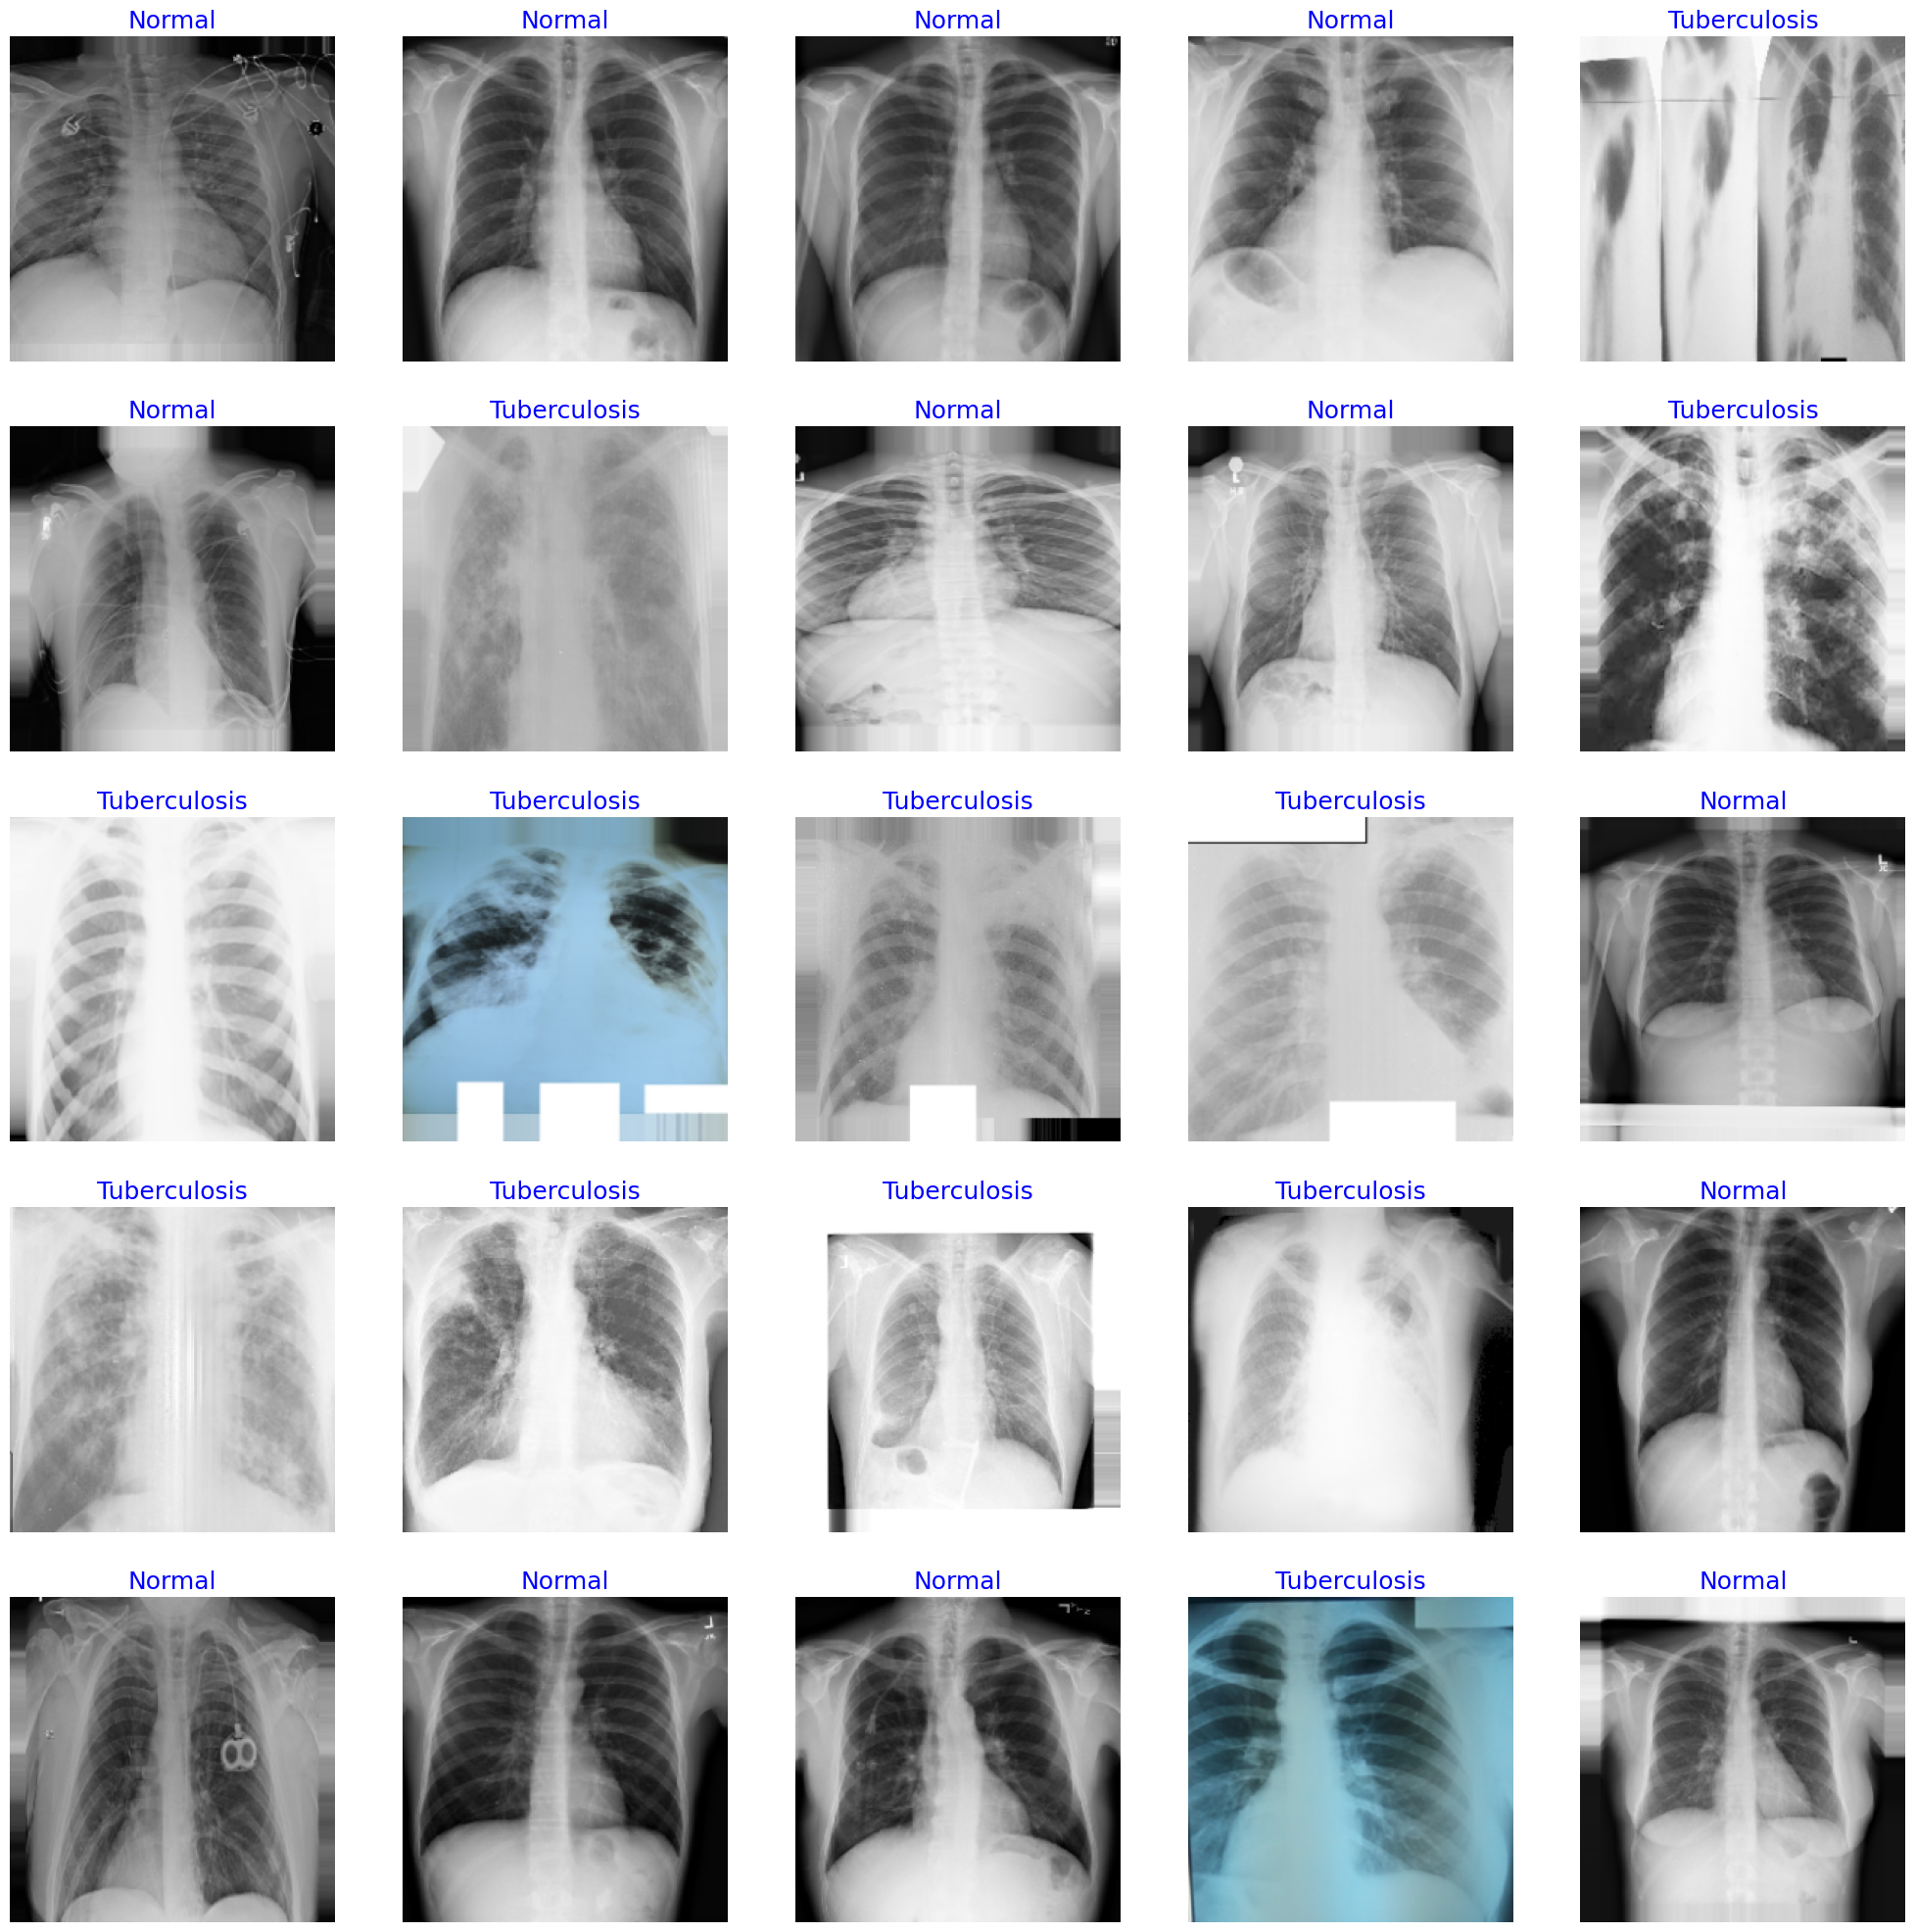

In [9]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())

    # Fetch a batch from the generator
    images, labels = next(gen)  # This batch is already shuffled

    plt.figure(figsize=(25, 25))
    num_images = min(25, len(labels))  # Show up to 25 images

    indices = np.random.choice(len(images), num_images, replace=False)  # Randomly select images without replacement

    for i, index in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        image = images[index]  # No need to divide by 255 as the generator already rescales
        plt.imshow(image)
        class_label_index = np.argmax(labels[index])
        class_name = classes[class_label_index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')

    plt.show()

# Show random image samples from the training set
show_image_samples(training_set)

Test Dataset

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Import the images from the test dataset.

test_set = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1300 images belonging to 2 classes.


Importing the VGG 16 model, creating a base model .
Base model is created from vgg 16. This is pretrained on the imagenet dataset.

In [12]:
# Import the VGG 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


Freezing the convolutional layer before training the model

In [13]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

Apply a Dense layer to convert these features into a single prediction per image.

Note : This is the place where we can add more layers such as Pooling layer; Flatten and Dense layers etc.

For now I am just adding a Flatten followed by the Dense layer.

### Sample... for adding Pooling (optional)
# global_average_layer = GlobalAveragePooling2D()

# prediction = Dense(NUM_CLASSES,activation='softmax')

In [14]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

Stacking the feature extractor vgg.input and two layers prediction

In [15]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Compiling the model - final step for configuring CNN

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Training the model


In [18]:
# fit the model

# history = model.fit_generator(
#   training_set,
#   validation_data=test_set,
#   epochs=5,
#   steps_per_epoch=len(training_set),
#   validation_steps=len(test_set)
# )

history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
122/122 [==============================] - 1755s 14s/step - loss: 0.1844 - accuracy: 0.9251 - val_loss: 0.0686 - val_accuracy: 0.9792
Epoch 2/5
122/122 [==============================] - 490s 4s/step - loss: 0.0909 - accuracy: 0.9656 - val_loss: 0.0786 - val_accuracy: 0.9692
Epoch 3/5
122/122 [==============================] - 490s 4s/step - loss: 0.0905 - accuracy: 0.9669 - val_loss: 0.0552 - val_accuracy: 0.9785
Epoch 4/5
122/122 [==============================] - 491s 4s/step - loss: 0.0677 - accuracy: 0.9744 - val_loss: 0.0359 - val_accuracy: 0.9838
Epoch 5/5
122/122 [==============================] - 490s 4s/step - loss: 0.0481 - accuracy: 0.9823 - val_loss: 0.0321 - val_accuracy: 0.9900


Evaluating the model

In [19]:
# Generate Validation set.
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1300 images belonging to 2 classes.


In [20]:
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 196s 10s/step - loss: 0.0432 - accuracy: 0.9828
loss: 0.04
accuracy: 0.98


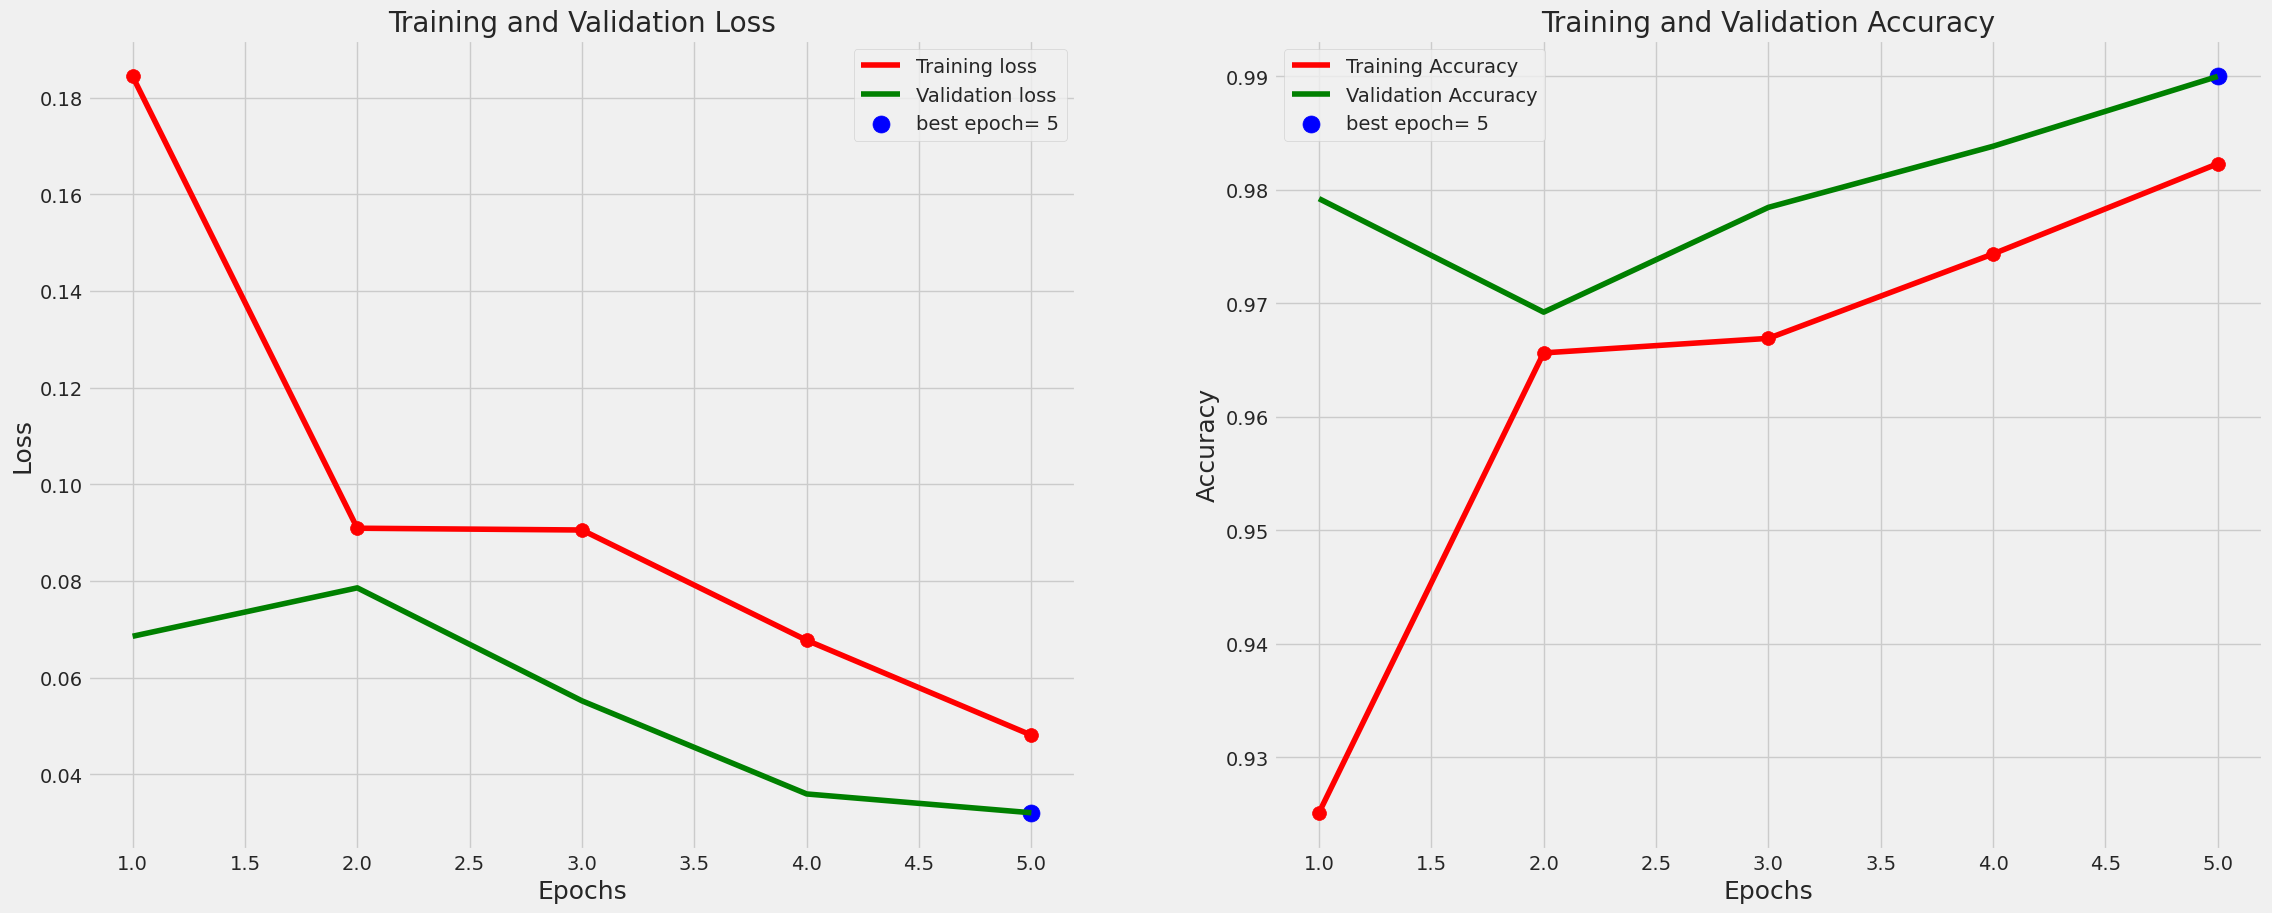

In [21]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)

changing to binary and shuffle to false


In [22]:
# Generate Validation set.
validation_set2 = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False,
    seed=42,
    class_mode="binary"
)

# validation_set2.reset()

Found 1300 images belonging to 2 classes.


In [23]:
# just capture the loss and accuray into val variable... unlike in pervious code to capture into loss0 and accuracy0. Just to showcase alternate way.

val = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(val[0]))
print("accuracy: {:.2f}".format(val[1]))

20/20 [==============================] - 128s 7s/step - loss: 0.0325 - accuracy: 0.9875
loss: 0.03
accuracy: 0.99


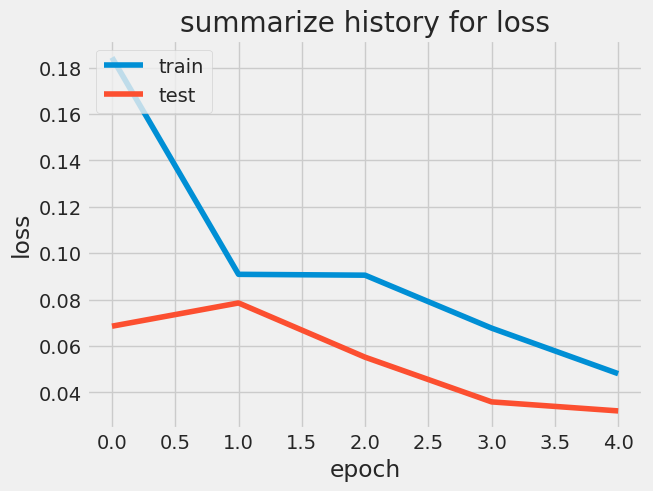

In [24]:
# summarize history for loss

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation (Test) loss')
plt.title('summarize history for loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

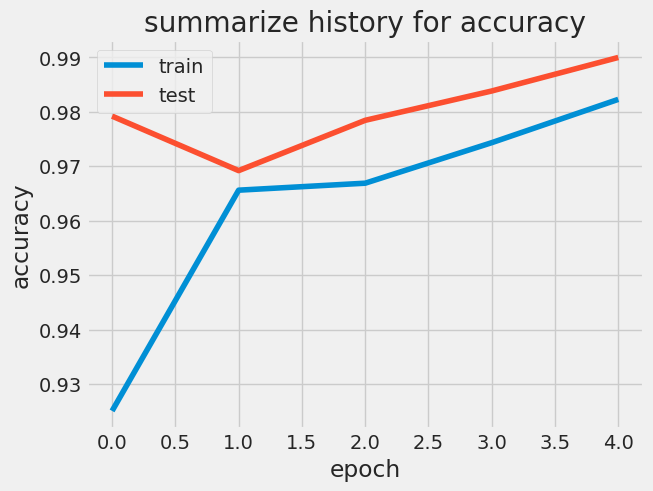

In [25]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('summarize history for accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

https://www.kaggle.com/code/dskagglemt/transferlearning-vgg16-xray-classification

MOBILENET V3





1. Insantiate a base model with pre-trained weights

In [26]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

In [27]:
mobilenet = MobileNetV3Small(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

4334752/4334752 [==============================] - 0s 0us/step


2. Freezing the base model

In [28]:
for layer in mobilenet.layers:
    layer.trainable= False



3. Creating a new model on top

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

x = Flatten()(mobilenet.output)

prediction = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Convert features of shape `base_model.output_shape[1:]` to vectors
#x = Flatten()(x)
model2 = Model(inputs=mobilenet.input, outputs=prediction)
#outputs = keras.layers.Dense(1, activation='sigmoid')(x)
#model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

compiling the model on new data

In [ ]:
# tell the model what cost and optimization method to use
model2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



Training the model

In [ ]:
history = model2.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  verbose=1
)

Epoch 1/5
79/79 [==============================] - 52s 617ms/step - loss: 0.5467 - accuracy: 0.8187 - val_loss: 0.4198 - val_accuracy: 0.8333
Epoch 2/5
79/79 [==============================] - 48s 606ms/step - loss: 0.4364 - accuracy: 0.8345 - val_loss: 0.4000 - val_accuracy: 0.8357
Epoch 3/5
79/79 [==============================] - 48s 605ms/step - loss: 0.4068 - accuracy: 0.8365 - val_loss: 0.4665 - val_accuracy: 0.8464
Epoch 4/5
79/79 [==============================] - 47s 601ms/step - loss: 0.3882 - accuracy: 0.8448 - val_loss: 0.3776 - val_accuracy: 0.8369
Epoch 5/5
79/79 [==============================] - 47s 601ms/step - loss: 0.3978 - accuracy: 0.8437 - val_loss: 0.4629 - val_accuracy: 0.8345


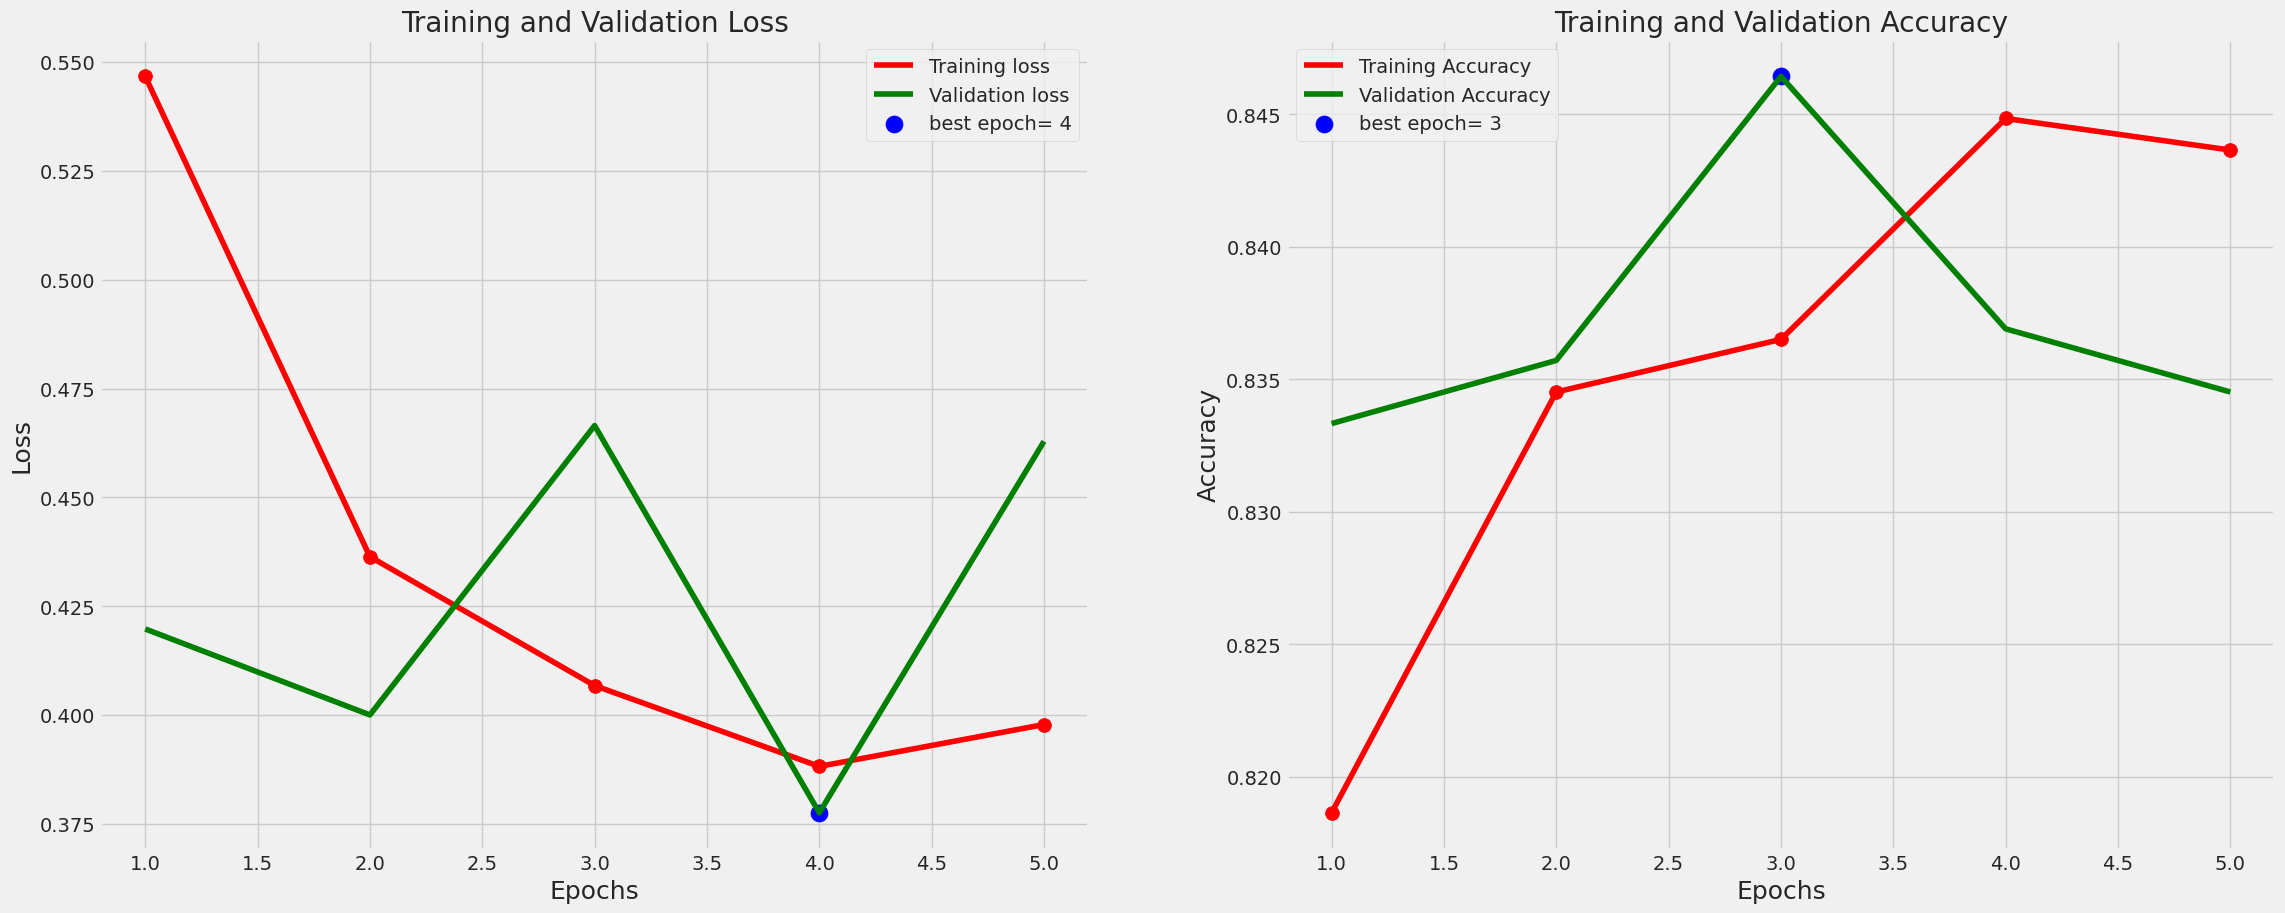

In [ ]:
loss_index=tr_plot(history,0)

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small, VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model


**Voting**

In [ ]:

weight_vgg = 0.60
weight_mobilenet = 0.40

# Validation Data Generator
BATCH_SIZE = 32

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for label alignment
)

# prediction
validation_set.reset()  # Reset to ensure alignment
preds_vgg = model.predict(validation_set, steps=np.ceil(validation_set.samples / validation_set.batch_size))
preds_mobilenet = model2.predict(validation_set, steps=np.ceil(validation_set.samples / validation_set.batch_size))

# combined predictions using weighted averaging
combined_preds = (weight_vgg * preds_vgg) + (weight_mobilenet * preds_mobilenet)

# class labels from the combined predictions
predicted_labels = np.argmax(combined_preds, axis=1)

# True labels
true_labels = validation_set.classes

# Accuracy of the voted ensemble
accuracy = np.mean(predicted_labels == true_labels)
print(f'Weighted Voting Ensemble Accuracy: {accuracy:.2f}')

Found 840 images belonging to 2 classes.
27/27 [==============================] - 7s 246ms/step
Weighted Voting Ensemble Accuracy: 0.98


**Stacking**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for label alignment
)

# Predict with both models (make sure models are loaded and compiled)
validation_set.reset()  # Reset to ensure alignment
preds_vgg = model.predict(validation_set, steps=np.ceil(validation_set.samples / validation_set.batch_size))
preds_mobilenet = model2.predict(validation_set, steps=np.ceil(validation_set.samples / validation_set.batch_size))

# Features for the meta-model will be the concatenation of predictions from both models
stacked_features = np.concatenate([preds_vgg, preds_mobilenet], axis=1)


Found 840 images belonging to 2 classes.
27/27 [==============================] - 7s 246ms/step


In [ ]:
# Meta-model definition
meta_input = Input(shape=(stacked_features.shape[1],))
meta_output = Dense(NUM_CLASSES, activation='softmax')(meta_input)
meta_model = Model(inputs=meta_input, outputs=meta_output)

# Compile the meta-model
meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare labels for training the meta-model
true_labels = validation_set.classes
from tensorflow.keras.utils import to_categorical
true_labels = to_categorical(true_labels, num_classes=NUM_CLASSES)

# Fit the meta-model
meta_model.fit(stacked_features, true_labels[:stacked_features.shape[0]], epochs=10, batch_size=32)


Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 0.7772 - accuracy: 0.0083
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.7190 - accuracy: 0.6667
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.8333
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6212 - accuracy: 0.8333
Epoch 5/10
27/27 [==============================] - 0s 1ms/step - loss: 0.5814 - accuracy: 0.8333
Epoch 6/10
27/27 [==============================] - 0s 1ms/step - loss: 0.5468 - accuracy: 0.8333
Epoch 7/10
27/27 [==============================] - 0s 1ms/step - loss: 0.5166 - accuracy: 0.8333
Epoch 8/10
27/27 [==============================] - 0s 1ms/step - loss: 0.4905 - accuracy: 0.8333
Epoch 9/10
27/27 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.8333
Epoch 10/10
27/27 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.8333


In [ ]:
# Evaluate the meta-model
meta_model_loss, meta_model_accuracy = meta_model.evaluate(stacked_features, true_labels[:stacked_features.shape[0]])
print(f"Meta-model loss: {meta_model_loss}")
print(f"Meta-model accuracy: {meta_model_accuracy}")

27/27 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.8333
Meta-model loss: 0.43706032633781433
Meta-model accuracy: 0.8333333134651184


Bagging

In [ ]:
# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Define the number of steps to use for evaluation
validation_steps = 20

# VGG model
loss_vgg, accuracy_vgg = model.evaluate(validation_set, steps=validation_steps)
print("VGG model loss: {:.2f}".format(loss_vgg))
print("VGG model accuracy: {:.2f}".format(accuracy_vgg))

# MobileNet model evaluation
loss_mobilenet, accuracy_mobilenet = model2.evaluate(validation_set, steps=validation_steps)
print("MobileNet model loss: {:.2f}".format(loss_mobilenet))
print("MobileNet model accuracy: {:.2f}".format(accuracy_mobilenet))

#  bagging prediciton (averaging predictions)
def predict_with_bagging(validation_set, steps):
    preds_vgg = model.predict(validation_set, steps=steps)
    preds_mobilenet = model2.predict(validation_set, steps=steps)
    final_preds = (preds_vgg + preds_mobilenet) / 2
    return np.argmax(final_preds, axis=1)

# Resetting the generator before predicting
validation_set.reset()

#  predictions with bagging
predicted_classes = predict_with_bagging(validation_set, validation_steps)
true_classes = validation_set.classes[:predicted_classes.size]  # Adjust size to match the batch count

# Calculate the accuracy of the ensemble
accuracy_ensemble = np.mean(predicted_classes == true_classes)
print("Ensemble model accuracy: {:.2f}".format(accuracy_ensemble))

Found 840 images belonging to 2 classes.
20/20 [==============================] - 12s 587ms/step - loss: 0.0355 - accuracy: 0.9891
VGG model loss: 0.04
VGG model accuracy: 0.99
20/20 [==============================] - 5s 255ms/step - loss: 0.5124 - accuracy: 0.8234
MobileNet model loss: 0.51
MobileNet model accuracy: 0.82
20/20 [==============================] - 6s 259ms/step
Ensemble model accuracy: 0.89


FLOPS

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_func = convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()

    # Calculate FLOPs by parsing the model graph
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

    return flops.total_float_ops  # Returns the total number of FLOPs in the model

In [ ]:
# Assuming 'model' is your VGG model and 'model2' is your MobileNet model

# Calculate FLOPs for VGG
vgg_flops = get_flops(model)
print(f"Total FLOPs for VGG model: {vgg_flops}")

# Calculate FLOPs for MobileNet
mobilenet_flops = get_flops(model2)
print(f"Total FLOPs for MobileNet model: {mobilenet_flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
34 ops no flops stats due to incomplete shapes.


Total FLOPs for VGG model: 0
Total FLOPs for MobileNet model: 0


170 ops no flops stats due to incomplete shapes.
